In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [5]:
era5 = xr.open_dataset('./data/cmcc_ERA5/1980_10_03_15_ERA5.nc')
era5

<xarray.Dataset>
Dimensions:  (lat: 281, lon: 881, time: 1)
Coordinates:
  * lat      (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float64 100.0 100.2 100.5 100.8 ... 319.2 319.5 319.8 320.0
  * time     (time) datetime64[ns] 1980-10-03T15:00:00
Data variables:
    fg10     (time, lat, lon) float32 ...
    i10fg    (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    t_500    (time, lat, lon) float32 ...
    t_300    (time, lat, lon) float32 ...
    vo_850   (time, lat, lon) float32 ...

In the following cell, figsize = (aspect * size, size)
(https://docs.xarray.dev/en/stable/user-guide/plotting.html#controlling-the-figure-size)

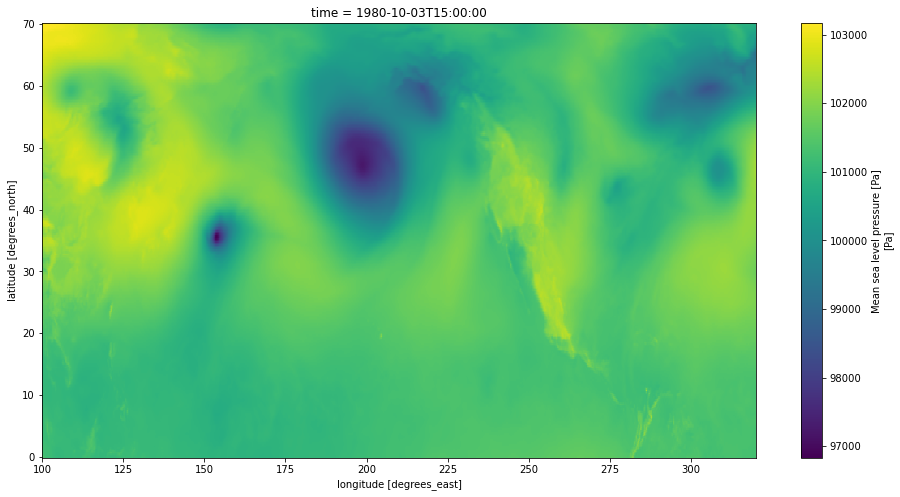

In [6]:
era5['msl'].plot(aspect=2, size=8)

Let's change the longitude range from [0, 360] to [-180, 180] to match our unstructured mesh.

Note: adding the original attributes 'units' and 'long_name' is fundamental to avoid the "Unsupported generic coordinates" error of cdo during the remapping.

In [7]:
print("Before conversion:", era5.lon.values[:5])
era5['lon'] = (era5.lon.values + 180) % 360 - 180
era5.lon.attrs['units'] = "degrees_east"
era5.lon.attrs['long_name'] = "longitude"
era5 = era5.sortby(era5.lon)
print("After conversion:", era5.lon.values[:5])

Before conversion: [100.   100.25 100.5  100.75 101.  ]
After conversion: [-180.   -179.75 -179.5  -179.25 -179.  ]


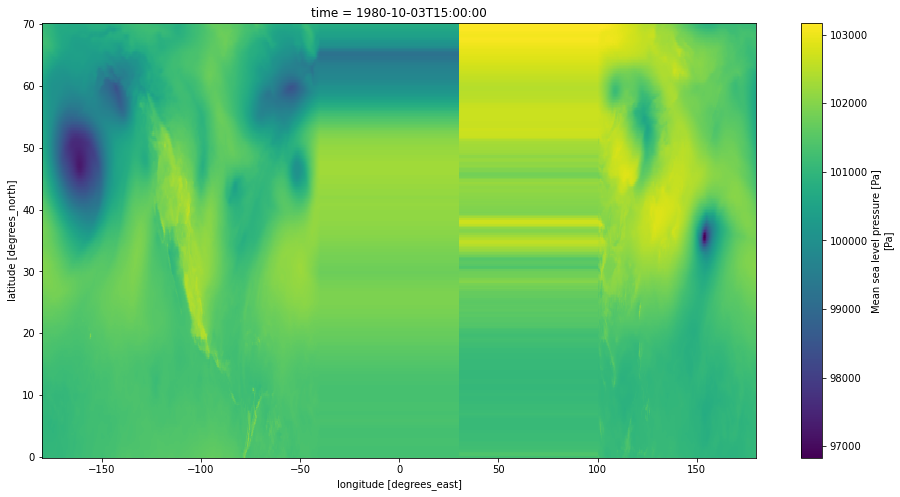

In [8]:
era5['msl'].plot(aspect=2, size=8)

Let's drop some variables for now

In [9]:
era5 = era5.drop_vars('fg10')
era5 = era5.drop_vars('i10fg')
era5 = era5.drop_vars('t_500')
era5 = era5.drop_vars('t_300')
era5 = era5.drop_vars('vo_850')
era5

<xarray.Dataset>
Dimensions:  (lat: 281, lon: 881, time: 1)
Coordinates:
  * lat      (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1980-10-03T15:00:00
Data variables:
    msl      (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...

In [7]:
era5.to_netcdf('./data/cmcc_ERA5/1980_10_03_15_ERA5_msl_sst.nc')

Now follow these steps in bash to map from a grid(the ERA5 we've alreay created) to another(the ESGF unstructured oceanic):
1. cd ./data
2. cdo griddes ./pbo_Omon_AWI-CM-1-1-MR_historical_r2i1p1f1_gn_198101-199012.nc > ./grid_info.txt
3. cdo -P PROCS remapcon,grid_info.txt ./cmcc_ERA5/1980_10_03_15_ERA5_msl_sst.nc output.nc

Note: PROCS=processes doing the remapping in parallel, hit "nproc" for more info

After mapping these variables to the unstructured mesh with cdo, we can inspect the result

In [10]:
out = xr.open_dataset('./data/output.nc')
out

<xarray.Dataset>
Dimensions:   (time: 1, ncells: 830305, vertices: 16)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-03T15:00:00
    lon       (ncells) float64 ...
    lat       (ncells) float64 ...
Dimensions without coordinates: ncells, vertices
Data variables:
    lon_bnds  (ncells, vertices) float64 ...
    lat_bnds  (ncells, vertices) float64 ...
    msl       (time, ncells) float32 ...
    sst       (time, ncells) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    Conventions:               CF-1.6
    history:                   Mon Dec 19 22:54:21 2022: cdo -P 8 remapcon,gr...
    CDO:                       Climate Data Operators version 2.0.4 (https://...
    cdo_openmp_thread_number:  8

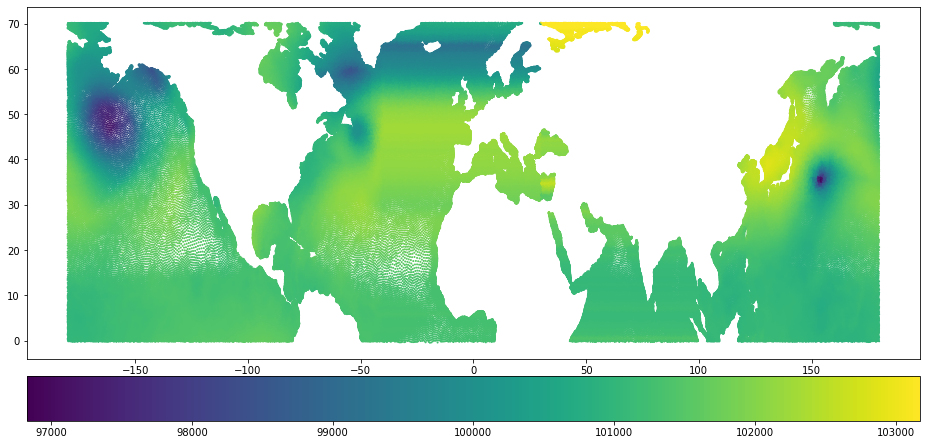

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(out.lon, out.lat, s=1, c=out.msl[0])
plt.colorbar(orientation='horizontal', pad=0.04)
plt.show()

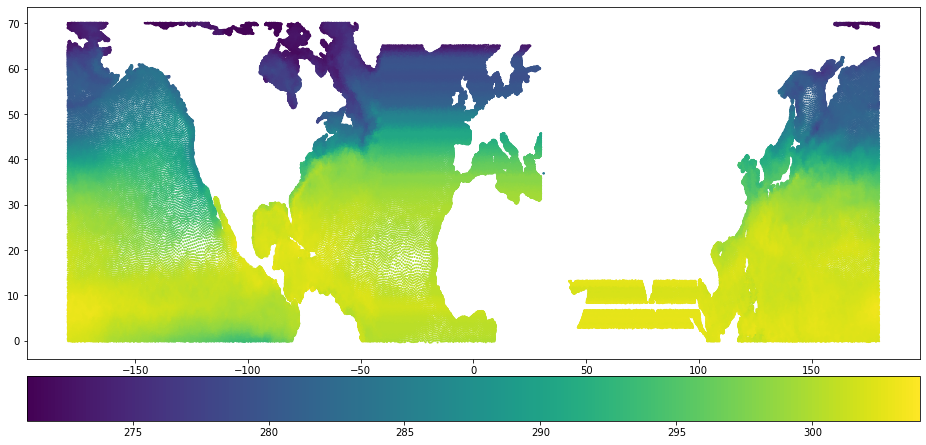

In [12]:
plt.figure(figsize=(16, 8))
plt.scatter(out.lon, out.lat, s=1, c=out.sst[0])
plt.colorbar(orientation='horizontal', pad=0.04)
plt.show()

Let's print the date we're gonna use to extract the cyclones of IBTrACS:

In [13]:
dates = out.time.values
dates

array(['1980-10-03T15:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
date = dates[0].astype(str).split('-')
print(date)
year = date[0]
month = date[1]
day = date[2].split('T')[0]
hour = date[2].split('T')[1]
print("Year:", year, "\nMonth:", month, "\nDay:", day, "\nHour:", hour)

['1980', '10', '03T15:00:00.000000000']
Year: 1980 
Month: 10 
Day: 03 
Hour: 15:00:00.000000000


Now go to "cmcc_pandas_IBTrACS_csv.ipynb" and retrieve the lon/lat values for each cyclone happening at that timestamp

In [15]:
lat = ['36.8365', '38.7285', '6.23471']
lon = ['156.148', '-21.8732', '153.373']

TODO

In [16]:
grid_rows = era5.lat.size
grid_cols = era5.lon.size
grid_ibtracs = np.zeros((grid_rows, grid_cols))
grid_ibtracs.shape

(281, 881)

In [17]:
#earth_circ_equator = 40075.017     # circumference measured at the equator, kilometers
#earth_circ_meridian = 40007.863    # circumference measured at the meridian, kilometers
#grid_res_lon = earth_circ_equator/era5.lon.size
#grid_res_lat = earth_circ_meridian/era5.lat.size
#print('Grid lon resolution:', grid_res_lon, ', grid lat resolution:', grid_res_lat)
#base_lon = grid_res_lon/100
#base_lat = grid_res_lat/100
base = 0.25

for i in range(len(lat)):
    cyclone_lat_refined = base*round(float(lat[i])/base)
    cyclone_lon_refined = base*round(float(lon[i])/base)
    print(lat[i], cyclone_lat_refined, lon[i], cyclone_lon_refined)


36.8365 36.75 156.148 156.25
38.7285 38.75 -21.8732 -21.75
6.23471 6.25 153.373 153.25


In [18]:
cyclone_lon_refined = round(float(lon[0])/base)
print(lon[0], cyclone_lon_refined)

156.148 625
